# All imports

In [1]:
! pip install tensorly

In [0]:
import os
from google_drive_downloader import GoogleDriveDownloader as gdd

import pandas as pd
import numpy as np
import seaborn as sns
import  matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix,lil_matrix
from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds
from sklearn.neighbors import NearestNeighbors

import tensorly as tl
from tensorly.decomposition import parafac

import warnings

In [0]:
%matplotlib inline
sns.set_style('darkgrid')

# Load data

In [4]:
if not os.path.exists('./data'):
  os.mkdir('./data')

gdd.download_file_from_google_drive(file_id='1r6U_EFULKXiuLPrIEAdoJ7W_1Xa7aJ3Q', dest_path='./data/movies.zip')

In [5]:
! unzip ./data/movies.zip -d ./data/unziped

Archive:  ./data/movies.zip
  inflating: ./data/unziped/links.csv  
  inflating: ./data/unziped/movies.csv  
  inflating: ./data/unziped/ratings.csv  
  inflating: ./data/unziped/tags.csv  
  inflating: ./data/unziped/u.data   


# EDA

This table contains all info about user - movie interaction by ratings.

In [4]:
ratings_df = pd.read_csv('./data/unziped/ratings.csv')
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


Luckily no nans

In [0]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
userId       100004 non-null int64
movieId      100004 non-null int64
rating       100004 non-null float64
timestamp    100004 non-null int64
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


Total number of users

In [0]:
ratings_df['userId'].nunique()

671

UserId - from 1 to 671 with no missing

In [0]:
sorted(list(ratings_df['userId'].unique()))

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

Total number of ratings is:

In [0]:
ratings_df.shape[0]

100004

Total number of movies is:

In [0]:
ratings_df['movieId'].nunique()

9066

MovieId from 1 to 163949 with missing values

In [0]:
print(sorted(list(ratings_df['movieId'].unique()), reverse=True))

[163949, 162672, 162542, 162376, 161944, 161918, 161830, 161594, 161155, 161084, 160718, 160656, 160590, 160567, 160565, 160563, 160440, 160438, 160271, 160080, 159972, 159858, 159755, 159690, 159462, 159093, 158956, 158528, 158314, 158238, 157667, 157407, 157296, 157200, 156726, 156609, 156607, 156387, 156025, 155820, 155611, 155392, 153584, 152844, 152173, 152091, 152081, 152079, 152077, 152057, 152025, 152017, 151639, 151307, 150856, 150548, 150401, 149830, 149612, 149606, 149590, 149572, 149532, 149406, 149354, 149352, 148956, 148888, 148881, 148652, 148626, 148372, 148238, 148168, 147845, 147426, 147037, 147010, 147006, 146688, 146682, 146656, 146604, 146501, 146443, 146309, 145935, 145839, 145775, 145307, 145150, 144976, 144714, 144620, 143859, 143657, 143472, 143410, 143385, 143377, 143257, 143255, 142997, 142536, 142507, 142488, 142448, 142422, 142258, 142240, 142192, 142068, 141956, 141890, 141886, 141866, 141749, 141718, 141688, 141668, 141422, 141124, 140928, 140880, 140816,

Al least 20 ratings were made by one user. Very active user made 2391 ratings.

In [0]:
ratings_df.groupby('userId').agg({'rating' : 'count'}).describe()

,rating
count,671.000000
mean,149.037258
std,231.226948
min,20.000000
25%,37.000000
50%,71.000000
75%,161.000000
max,2391.000000


Text(0.5, 0, 'number of ratings per user')

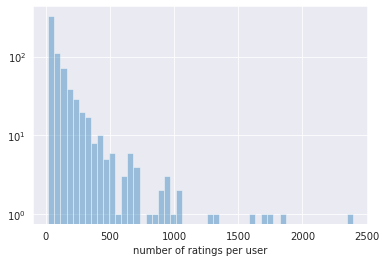

In [0]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sns.distplot(ratings_df.groupby('userId').agg({'rating' : 'count'}).values, ax=ax, kde=False)
ax.set_yscale('log')
ax.set_xlabel("number of ratings per user")

Ratings distribution

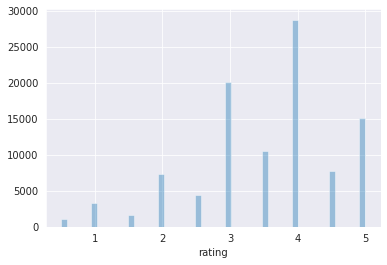

In [0]:
sns.distplot(ratings_df['rating'],kde=False)

We can see that ratings are ordinal, not numerical.

Our user - item interaction matrix is very sparse. Less than a 2 percents of all cells are filled.

In [0]:
ratings_df.shape[0] / (ratings_df['userId'].nunique() * ratings_df['movieId'].nunique())

0.016439141608663475

Table with tag information

In [0]:
tags_df = pd.read_csv('./data/unziped/tags.csv')
tags_df.head()

,userId,movieId,tag,timestamp
0,15,339,sandra 'boring' bullock,1138537770
1,15,1955,dentist,1193435061
2,15,7478,Cambodia,1170560997
3,15,32892,Russian,1170626366
4,15,34162,forgettable,1141391765


Luckily no nans

In [0]:
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 4 columns):
userId       1296 non-null int64
movieId      1296 non-null int64
tag          1296 non-null object
timestamp    1296 non-null int64
dtypes: int64(3), object(1)
memory usage: 40.6+ KB


Total number of tags

In [0]:
tags_df['tag'].nunique()

582

Extremly active user added 401 tags

In [0]:
tags_df.groupby('userId').agg({'tag':'count'}).describe()

,tag
count,61.000000
mean,21.245902
std,58.614462
min,1.000000
25%,2.000000
50%,4.000000
75%,9.000000
max,401.000000


Text(0.5, 0, 'number of tags per user')

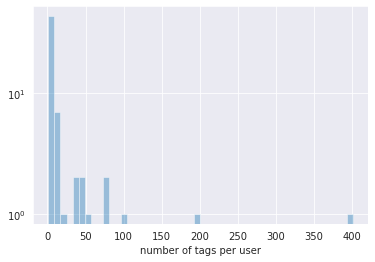

In [0]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sns.distplot(tags_df.groupby('userId').agg({'tag' : 'count'}).values, ax=ax, kde=False)
ax.set_yscale('log')
ax.set_xlabel('number of tags per user')

We have more than 1 tag per movie.

In [0]:
tags_df.groupby('movieId').agg({'tag' : 'count'})

,tag
movieId,
1,1
5,1
47,10
50,1
104,1
...,...
161582,1
163056,1
163949,1


But only part of movies has tags!!!

In [0]:
tags_df['movieId'].nunique()

689

# Evaluation metrics implementation

In [0]:
def precision_at_k_old(predicted, actual, k):
  assert len(predicted) >= k
  intersection = set(predicted[:k]) & set(actual)
  return len(intersection) / min(k,len(actual))

In [0]:
def average_precision_old(predicted, actual):
  tmp = 0
  actual_length = len(predicted)
  for i in range(actual_length):
    if predicted[i] in actual:
      tmp += precision_at_k(predicted[:i+1], actual, i+1)
  return tmp / actual_length

In [0]:
def mean_average_precision_old(predicted_list, actual_list):
  tmp = 0
  cnt = 0
  for predicted, actual in zip(predicted_list, actual_list):
    if len(actual) != 0:
      tmp += average_precision(predicted, actual)
      cnt += 1
  assert cnt != 0
  return tmp / cnt
    

In [0]:
def precision_at_k(predicted, actual, k):
  assert len(predicted) >= k
  intersection = set(predicted[:k]) & set(actual)
  return len(intersection) / k

In [0]:
def average_precision_at_k(predicted, actual, k):
  tmp = 0
  if len(predicted) < k:
    warnings.warn("Length of predict is less than k")
  actual_length = min(k,len(predicted))
  for i in range(actual_length):
    if predicted[i] in actual:
      tmp += precision_at_k(predicted[:i+1], actual, i+1)
  return tmp / actual_length

In [0]:
def mean_average_precision_at_k(predicted_list, actual_list, k):
  tmp = 0
  cnt = 0
  for predicted, actual in zip(predicted_list, actual_list):
    if len(actual) != 0:
      tmp += average_precision_at_k(predicted, actual, k)
      cnt += 1
  assert cnt != 0
  return tmp / cnt
    

# Collaborative filtering recommenders

There is no time changing!!!!

In [34]:
ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'], unit='s')
ratings_df['timestamp'].sort_values()

52635   1995-01-09 11:46:49
52641   1995-01-09 11:46:49
52684   1995-01-09 11:46:49
56907   1996-03-30 19:00:12
56909   1996-03-30 19:00:12
                ...        
35125   2016-10-16 13:05:31
35172   2016-10-16 13:06:57
35140   2016-10-16 13:08:02
35096   2016-10-16 13:08:20
35069   2016-10-16 17:57:24
Name: timestamp, Length: 100004, dtype: datetime64[ns]

At first timeseries split

In [0]:
X_train = ratings_df.loc[ratings_df['timestamp'] <= '2007-01-01 00:00:00', ['userId', 'movieId', 'rating']]
X_test = ratings_df.loc[ratings_df['timestamp'] > '2007-01-01 00:00:00', ['userId', 'movieId', 'rating']]

In [62]:
X_train.shape

(63501, 3)

In [63]:
X_test.shape

(36503, 3)

User train/test intersection

In [66]:
len(set(X_train['userId'].unique()) & set(X_test['userId'].unique()))

24

## Most popular recommender

In [0]:
def prepare_ground_truth(X_test, preference_threshold=3):
  grouped_by_user = X_test.groupby('userId')
  test_all_users_list = []
  for user in X_test['userId'].unique():
    group = grouped_by_user.get_group(user)
    user_list = list(group.loc[group['rating']>=preference_threshold,'movieId'].values)
    test_all_users_list.append(user_list)
  return test_all_users_list
  

In [0]:
class MostPopularRecommender():
  def __init__(self):
    pass
  
  def fit(self, X_train):
    assert type(X_train) == pd.DataFrame
    X_train['relevance'] = X_train['rating'].apply(lambda x: 1 if x >= 3 else 0)
    self.most_popular = list(X_train.groupby('movieId').agg({'relevance' : 'sum'}).sort_values(by='relevance', ascending=False).index)
  
  def predict(self, X_test, top_n):
    recommendation_list = []
    for user in X_test['userId'].unique():
      recommendation_list.append(self.most_popular[:top_n])
    return recommendation_list 

In [0]:
most_popular_recommender = MostPopularRecommender()
most_popular_recommender.fit(X_train)
predicted_all_users_list = most_popular_recommender.predict(X_test, top_n=10)

In [0]:
test_all_users_list = prepare_ground_truth(X_test)

In [69]:
mean_average_precision_at_k(predicted_all_users_list, test_all_users_list,k=10)

0.21911295189812308

## SVD recommender

In [0]:
def prepare_ground_truth_for_svd(X_test, X_train,preference_threshold=3):
  grouped_by_user = X_test.groupby('userId')
  test_all_users_list = []
  for user in X_test['userId'].unique():
    if user in X_train['userId'].unique():
      group = grouped_by_user.get_group(user)
      user_list = list(group.loc[group['rating']>=preference_threshold,'movieId'].values)
      test_all_users_list.append(user_list)
  return test_all_users_list

In [0]:
class SVDRecommender():
  def __init__(self, k):
    self.k = k

  
  def fit(self, X_train):
    self.X_train = X_train
    R_df = X_train.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
    R = R_df.as_matrix()
    user_ratings_mean = np.mean(R, axis = 1)
    R_demeaned = R - user_ratings_mean.reshape(-1, 1)
    
    
    U, sigma, Vt = svds(R_demeaned, self.k)
    sigma = np.diag(sigma)
    all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
    self.preds_df = pd.DataFrame(all_user_predicted_ratings, columns = R_df.columns)
    self.preds_df.index = R_df.index
    
  def predict(self, X_test, top_n):
    predicted_all_users_list = []
    for user in X_test['userId'].unique():
      if user in self.X_train['userId'].unique():
        predicted_all_users_list.append(list(self.preds_df.loc[user].sort_values(ascending=False).index[:top_n]))
    return predicted_all_users_list 

In [79]:
svd_rec = SVDRecommender(5)
svd_rec.fit(X_train)
predicted_all_users_list = svd_rec.predict(X_test,10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


In [0]:
test_all_users_list = prepare_ground_truth_for_svd(X_test, X_train)

In [81]:
mean_average_precision_at_k(predicted_all_users_list, test_all_users_list,k=10)

0.02402173913043478

Evaluate on train

In [0]:
predicted_all_users_list = svd_rec.predict(X_train, top_n=10)

In [0]:
test_all_users_list = prepare_ground_truth_for_svd(X_train, X_train)

In [85]:
mean_average_precision_at_k(predicted_all_users_list, test_all_users_list,k=10)

0.4752905756270025

# Tensor factorization

In [0]:
merged_ratings_df = pd.merge(ratings_df.loc[:,['userId', 'rating', 'movieId']], tags_df.loc[:,['movieId', 'tag']], how='inner', on='movieId')

In [0]:
merged_ratings_df

,userId,rating,movieId,tag
0,1,3.0,1061,emotional
1,1,3.0,1061,revenge
2,1,3.0,1061,true story
3,19,3.0,1061,emotional
4,19,3.0,1061,revenge
...,...,...,...,...
63120,624,3.5,134859,toplist15
63121,624,3.0,139642,tivo
63122,663,4.0,139642,tivo
63123,624,3.0,140725,tivo


In [0]:
merged_ratings_df.isnull().any()

userId     False
rating     False
movieId    False
tag        False
dtype: bool

In [0]:
n_tags = merged_ratings_df['tag'].nunique()
n_users = merged_ratings_df['userId'].nunique()
n_movies = merged_ratings_df['movieId'].nunique()

In [0]:
n_tags

566

In [0]:
n_users

670

In [0]:
n_movies

630

In [0]:
rating_tensor = np.zeros((n_tags, n_users, n_movies))

In [0]:
users_dict = {user:idx for idx, user in enumerate(merged_ratings_df['userId'].unique())}
movies_dict = {movie:idx for idx, movie in enumerate(merged_ratings_df['movieId'].unique())}

In [0]:
grouped_by_tag_df = merged_ratings_df.groupby('tag')
for i, tag in enumerate(merged_ratings_df['tag'].unique()):
  layer = np.zeros((n_users, n_movies))
  for index, row in grouped_by_tag_df.get_group(tag).iterrows():
    layer[users_dict[row['userId']]][movies_dict[row['movieId']]] = row['rating']
  rating_tensor[i] = layer

In [0]:
rating_tensor

array([[[3. , 0. , 0. , ..., 0. , 0. , 0. ],
        [3. , 0. , 0. , ..., 0. , 0. , 0. ],
        [3.5, 0. , 0. , ..., 0. , 0. , 0. ],
        ...,
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ]],

       [[3. , 0. , 0. , ..., 0. , 0. , 0. ],
        [3. , 0. , 0. , ..., 0. , 0. , 0. ],
        [3.5, 0. , 0. , ..., 0. , 0. , 0. ],
        ...,
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ]],

       [[3. , 0. , 0. , ..., 0. , 0. , 0. ],
        [3. , 0. , 0. , ..., 0. , 0. , 0. ],
        [3.5, 0. , 0. , ..., 0. , 0. , 0. ],
        ...,
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ]],

       ...,

       [[0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. 

In [0]:
rating_tensor = tl.tensor(rating_tensor)

In [0]:
%%time
factors = parafac(rating_tensor, rank=40)

CPU times: user 33min 24s, sys: 3min 6s, total: 36min 30s
Wall time: 23min 31s


In [0]:
reconstructed_rating_tensor = tl.kruskal_to_tensor(factors)

In [0]:
inverse_movies_dict = {value:key for key, value in movies_dict.items()}
predicted_all_users_list = []
for userId in merged_ratings_df['userId'].unique():
  prediction_list = []
  layer = np.zeros((n_tags, n_movies))
  for i in range(n_tags):
    layer[i] = reconstructed_rating_tensor[i][users_dict[userId]][:]
  
  layer = layer.T
  max_list = []
  for j in range(n_movies):
    max_list.append((j, max(layer[j][:])))

  sorted_list = sorted(max_list, key=lambda pair: pair[1], reverse=True)
  for i in range(5):
    prediction_list.append(inverse_movies_dict[sorted_list[i][0]])
  predicted_all_users_list.append(prediction_list)

In [0]:
len(predicted_all_users_list)

670

In [0]:
test_all_users_list = prepare_ground_truth_for_svd(merged_ratings_df.loc[:, ['userId', 'movieId', 'rating']], merged_ratings_df.loc[:, ['userId', 'movieId', 'rating']])

In [0]:
len(test_all_users_list)

670

Evaluated only on train

In [0]:
mean_average_precision(predicted_all_users_list, test_all_users_list)

0.7889770459081846

# Bonus

In [0]:
class Recommender():
  def __init__(self, ratings_df, k):
    self.ratings_df = ratings_df
    self.k = k
    self.__make_factorization()
    self.nbrs_tree = NearestNeighbors(algorithm='kd_tree').fit(self.I)
    self.nbrs_brute = NearestNeighbors(algorithm='brute').fit(self.I)
    
  def __make_factorization(self):
    R_df = self.ratings_df.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
    R = R_df.as_matrix()
    user_ratings_mean = np.mean(R, axis = 1)
    R_demeaned = R - user_ratings_mean.reshape(-1, 1)
    U, _, It = svds(R_demeaned, self.k)
    self.U = pd.DataFrame(U, index=R_df.index)
    self.I = pd.DataFrame(It.T, index=R_df.columns)
  
  def get_user(self, userId):
    return self.U.loc[userId,:]
  
  def get_item(self, itemId):
    return self.I.loc[itemId,:]
  
  def make_recommendation_brute(self, userId, top_n):
    self.nbrs_brute.kneighbors(np.matrix(self.U.loc[userId,:]),n_neighbors=top_n)
    
  def make_recommendation_tree(self, userId, top_n):
    self.nbrs_tree.kneighbors(np.matrix(self.U.loc[userId,:]),n_neighbors=top_n)
    
    
  

In [88]:
rec = Recommender(ratings_df=ratings_df, k=10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


In [89]:
%%timeit 
for i in range(1,500):
  rec.make_recommendation_brute(i, top_n=10)

1 loop, best of 3: 806 ms per loop


In [90]:
%%timeit 
for i in range(1,500):
  rec.make_recommendation_tree(i, top_n=10)

1 loop, best of 3: 477 ms per loop


Some visualization, if needed

Text(0, 0.5, 'time in ms for 500 queries')

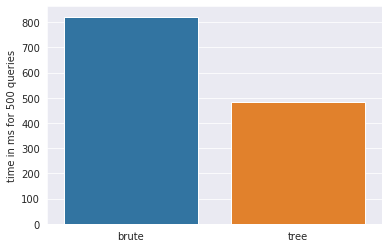

In [0]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sns.barplot(x=['brute', 'tree'], y=[822, 484], ax=ax)
ax.set_ylabel("time in ms for 500 queries")